<a href="https://colab.research.google.com/github/flow4u/public/blob/master/Sterftecijfers_Nederland_COVID_19_periode_vergelijken_met_eerdere_jaren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deaths of the Netherlands

**The 'interesting tables and graphs' are all the way at the bottom.**
Unlike other tables and graphs, full disclosure on how the tables and graphs are created from which source and how the data was processed.

Most likely this Notebook will be updated every Friday around 15:00 CET. However, feel free to make a copy and run it by yourself.

*   **Source:** CBS Open data, no other data is used
*   **Note:** Everything is normalized to: deaths per 100.000 per week for the specific year
    * this makes comparison possible because it eliminates the problem of:
       * different number of weeks per year
       * because some years have 'broken' week for Week 53 (not full 7 days):
          * Rule 1: if Week 53 in year x and Week 0 in year x+1 => Week 53 = Week 53 + Week 0, Week 0 is deleted
          * Rule 2: If Week 53 in year x and Week 1 in year x+1 ==> Week 1 = Week 1 + Week 53, Week 53 is seleted
       * different population sizes
          * Population is calculated by interpolation of Population on 1/1 year x and Population 1/1 year x+1

## Setting things up

In [1]:
#@title
# installing the necessary libraries for this notebook
!pip install cbsodata
import cbsodata
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
#@title
# Defining the required global variables
## get current year
current_year = int(datetime.now().year)
next_year = str(datetime.now().year + 1)

# some graph settings
## style
plt.style.use('seaborn-darkgrid')

## create a color palette
palette = plt.get_cmap('Dark2_r')

## Getting CBS data




### Getting table 70895ned data

*   Perioden
*   Overledenen_1 (diseased)

Table 70895ned contains diseased from 1995 till now on weekly basis.

In [3]:
#@title
# get CBS data
filtering = "((Geslacht eq '1100')) and ((LeeftijdOp31December eq '10000'))"
selection = ['Perioden', 'Overledenen_1']
data = pd.DataFrame(cbsodata.get_data('70895ned',
                                      filters=filtering,
                                      select=selection))

# remove all non Jaar-Week
data = data[data['Perioden'].map(len) > 5]

# making Perioden usefull by splitting up in Jaar, Week, Gebroken
# Gebroken, most likely Week 53 and Week 1, or Week 53 and Week 0 are not full 7 days records
data['Jaar'] = [x[0:4] for x in data['Perioden']]
data['Gebroken'] = ['' if x.find('(') == -1 else x[x.find('('):] for x in data['Perioden']]
data['Week'] = [int(x[10:]) if x.find('(') == -1 else int(x[10:x.find('(') - 1]) for x in data['Perioden']]

# Fixing Gebroken
# rule 1: if Week 0 then Week 53 = Week 53 + Week 0 next year
# Rule 2: if no Week 0 then Week 1 = Week 1 + Week 53 previous year
data.drop([0], inplace=True)
data.reset_index(drop=True, inplace=True)
item = 'Overledenen_1'
for i in range(len(data)):
    if data.loc[i, 'Week'] == 53 and data.loc[i, 'Gebroken'] != '':
        if data.loc[i+1, 'Week'] == 0:
            data.loc[i, item] = data.loc[i, item] + data.loc[i + 1, item]
            # when that week is fixed, remove make 'gebroken' empty
            data.loc[i, 'Gebroken'] = ''
        else:
            data.loc[i + 1, item] = data.loc[i + 1, item] + data.loc[i, item]
            # when that week is fixed, remove make 'gebroken' empty
            data.loc[i + 1, 'Gebroken'] = ''

# remove all 'Gebroken' - non-fixed
data = data[data['Gebroken'].map(len) < 2]
# reset the index
data.reset_index(drop=True, inplace=True)
# remove no longer needed columns
data.drop(['Gebroken', 'Perioden'], axis=1, inplace=True)

# Making sure Jaar is of right type
data['Jaar'] = data['Jaar'].astype('int')

# Setting the order of the dataframe
data = data[['Jaar', 'Week', 'Overledenen_1']]

# Copy data into df_overledenen_1995_current and print table
df_70895ned = data.copy()
df_70895ned['Week'].astype('int')
df_70895ned['Jaar'].astype('int')
print(tabulate(df_70895ned, headers=['Jaar', 'Week', 'Overledenen_1'], tablefmt='orgtbl'))

|      |   Jaar |   Week |   Overledenen_1 |
|------+--------+--------+-----------------|
|    0 |   1995 |      1 |            2719 |
|    1 |   1995 |      2 |            2823 |
|    2 |   1995 |      3 |            2609 |
|    3 |   1995 |      4 |            2664 |
|    4 |   1995 |      5 |            2577 |
|    5 |   1995 |      6 |            2536 |
|    6 |   1995 |      7 |            2551 |
|    7 |   1995 |      8 |            2510 |
|    8 |   1995 |      9 |            2490 |
|    9 |   1995 |     10 |            2770 |
|   10 |   1995 |     11 |            2800 |
|   11 |   1995 |     12 |            2786 |
|   12 |   1995 |     13 |            2634 |
|   13 |   1995 |     14 |            2717 |
|   14 |   1995 |     15 |            2645 |
|   15 |   1995 |     16 |            2691 |
|   16 |   1995 |     17 |            2645 |
|   17 |   1995 |     18 |            2628 |
|   18 |   1995 |     19 |            2486 |
|   19 |   1995 |     20 |            2482 |
|   20 |  

### Getting table 70072NED

*   Perioden
*   TotaleBevolking_1 (population on 1/1)

This covers period 1995-2020


In [4]:
#@title
# getting the data
filtering = "substringof('NL',RegioS)"
selection = ['Perioden', 'TotaleBevolking_1']
data = pd.DataFrame(cbsodata.get_data('70072NED',
                                      select=selection,
                                      filters=filtering
                                      ))
data = data.rename(columns={'Perioden': 'Jaar'})
df_70072NED = data.copy()
df_70072NED['Jaar'].astype('int')
print(tabulate(df_70072NED, headers=['Jaar', 'TotaleBevolking_1'], tablefmt='orgtbl'))

|    |   Jaar |   TotaleBevolking_1 |
|----+--------+---------------------|
|  0 |   1995 |         1.54241e+07 |
|  1 |   1996 |         1.54939e+07 |
|  2 |   1997 |         1.55671e+07 |
|  3 |   1998 |         1.56542e+07 |
|  4 |   1999 |         1.57602e+07 |
|  5 |   2000 |         1.5864e+07  |
|  6 |   2001 |         1.59871e+07 |
|  7 |   2002 |         1.61053e+07 |
|  8 |   2003 |         1.61926e+07 |
|  9 |   2004 |         1.6258e+07  |
| 10 |   2005 |         1.63055e+07 |
| 11 |   2006 |         1.63342e+07 |
| 12 |   2007 |         1.6358e+07  |
| 13 |   2008 |         1.64054e+07 |
| 14 |   2009 |         1.64858e+07 |
| 15 |   2010 |         1.6575e+07  |
| 16 |   2011 |         1.66558e+07 |
| 17 |   2012 |         1.67303e+07 |
| 18 |   2013 |         1.67796e+07 |
| 19 |   2014 |         1.68293e+07 |
| 20 |   2015 |         1.69007e+07 |
| 21 |   2016 |         1.69791e+07 |
| 22 |   2017 |         1.70815e+07 |
| 23 |   2018 |         1.71811e+07 |
| 24 |   201

### Getting table 84646NED

*   Perioden
*   Bevolking_1 (population on 1/1)

This is a prediction of the size of the population on 1/1 for the current and future years. We'll be using current and next year.



In [5]:
#@title
# getting the data
filtering = "((Perioden eq '"+str(current_year)+"JJ00') or (Perioden eq '"+str(next_year)+"JJ00')) and ((Geslacht eq 'T001038')) and ((Leeftijd eq '10000'))"
selection = ['Perioden', 'Bevolking_1']
data = pd.DataFrame(cbsodata.get_data('84646NED',
                                      select=selection,
                                      filters=filtering
                                      ))
# Rename Bevolking to match df_70072NED
data = data.rename(columns={'Bevolking_1': 'TotaleBevolking_1', 'Perioden': 'Jaar'})

df_84646NED = data.copy() 
df_84646NED['Jaar'].astype('int')
print(tabulate(df_84646NED, headers=['Jaar', 'TotaleBevolking_1'], tablefmt='orgtbl' ))

|    |   Jaar |   TotaleBevolking_1 |
|----+--------+---------------------|
|  0 |   2021 |            17550226 |
|  1 |   2022 |            17685368 |


### Creating one table with population from 1995 to current year + 1

In [6]:
#@title
# Combining tables df_70072NED and df_84646NED to have one table population from 1995 onwards
df_population = df_70072NED.copy()
df_population = pd.concat([df_70072NED, df_84646NED])

# To make interpolation easy, add Week=1 for all
df_population['Week'] = 1
df_population['Week'].astype('int')
df_population['Jaar'].astype('int')
df_population = df_population[['Jaar', 'Week', 'TotaleBevolking_1']]
print(tabulate(df_population, headers=['Jaar', 'Week', 'TotaleBevolking_1'], tablefmt='orgtbl' ))

|    |   Jaar |   Week |   TotaleBevolking_1 |
|----+--------+--------+---------------------|
|  0 |   1995 |      1 |         1.54241e+07 |
|  1 |   1996 |      1 |         1.54939e+07 |
|  2 |   1997 |      1 |         1.55671e+07 |
|  3 |   1998 |      1 |         1.56542e+07 |
|  4 |   1999 |      1 |         1.57602e+07 |
|  5 |   2000 |      1 |         1.5864e+07  |
|  6 |   2001 |      1 |         1.59871e+07 |
|  7 |   2002 |      1 |         1.61053e+07 |
|  8 |   2003 |      1 |         1.61926e+07 |
|  9 |   2004 |      1 |         1.6258e+07  |
| 10 |   2005 |      1 |         1.63055e+07 |
| 11 |   2006 |      1 |         1.63342e+07 |
| 12 |   2007 |      1 |         1.6358e+07  |
| 13 |   2008 |      1 |         1.64054e+07 |
| 14 |   2009 |      1 |         1.64858e+07 |
| 15 |   2010 |      1 |         1.6575e+07  |
| 16 |   2011 |      1 |         1.66558e+07 |
| 17 |   2012 |      1 |         1.67303e+07 |
| 18 |   2013 |      1 |         1.67796e+07 |
| 19 |   2014

### Creating table df_1995_current

with average weekly diseased per 100.000

*   with average weekly diseased per 100.000






In [7]:
#@title
# temp is there to remove weeks that were temporarily added for interpolation
df_70895ned.reset_index(drop=True, inplace=True)
temp = df_70895ned['Jaar'].count()
print(temp)

# Add all weeks of the current year not yet in the dataframe
latest_week = int(df_70895ned['Week'].iloc[-1])
latest_year = int(df_70895ned['Jaar'].iloc[-1])
for i in range(latest_week + 1, 53):
    add_row = {'Jaar': latest_year, 'Week': i}
    df_70895ned = df_70895ned.append(add_row, ignore_index=True)
# add first week of next year to get the predicted population, needed for interpolation of current year
df_70895ned = df_70895ned.append({'Jaar': int(latest_year+1), 'Week': int(1)}, ignore_index=True)

# Add population to Week 1 in df_70895ned
df_1995_current = df_70895ned.copy()
df_1995_current['Week'] = df_1995_current['Week'].astype('int')
df_1995_current['Jaar'] = df_1995_current['Jaar'].astype('int')
df_population['Week'] = df_population['Week'].astype('int')
df_population['Jaar'] = df_population['Jaar'].astype('int')
df_1995_current = pd.merge(df_1995_current, df_population, how='left', left_on=['Jaar', 'Week'], right_on=['Jaar', 'Week'])

# Interpolate for all other weeks
df_1995_current['TotaleBevolking_1'] = df_1995_current['TotaleBevolking_1'].interpolate().astype(float)

# Remove added Jaar and Week
df_1995_current.drop(df_1995_current.index[temp:], inplace=True)
df_1995_current.reset_index(drop=True, inplace=True)

# Normalize diseased per week per 100.000
df_1995_current['Overledenen Genormaliseerd'] = (df_1995_current['Overledenen_1'] / df_1995_current['TotaleBevolking_1'] * 100000).round(3)

# drop unnecessary columns and print table
df_1995_current.drop(columns=['Overledenen_1', 'TotaleBevolking_1'], axis=1, inplace=True)
print(tabulate(df_1995_current, headers=['Jaar', 'Week', 'Overleden Genormaliseerd']))

1355
        Jaar    Week    Overleden Genormaliseerd
----  ------  ------  --------------------------
   0    1995       1                      17.628
   1    1995       2                      18.301
   2    1995       3                      16.912
   3    1995       4                      17.267
   4    1995       5                      16.702
   5    1995       6                      16.435
   6    1995       7                      16.53
   7    1995       8                      16.263
   8    1995       9                      16.132
   9    1995      10                      17.945
  10    1995      11                      18.138
  11    1995      12                      18.045
  12    1995      13                      17.059
  13    1995      14                      17.595
  14    1995      15                      17.128
  15    1995      16                      17.424
  16    1995      17                      17.125
  17    1995      18                      17.013
  18    1995    

### Getting table 37530ned data

*   Perioden
*   SterftePer1000Inwoners_2 (diseased per 1000)

Table 37530ned contains diseased from 1950 till 2014 on yearly basis. We'll be using 1950-1994

In [8]:
#@title
# Get CBS data
filtering = "((LeeftijdOp31December eq 'aa')) and ((BurgerlijkeStaat eq '5')) and ((Perioden le '1995'))"
selection = ['Perioden', 'SterftePer1000Inwoners_2']
data = pd.DataFrame(cbsodata.get_data('37530ned',
                                      select=selection,
                                      filters=filtering
                                      ))

# Function to establish how many weeks each year has
def num_weeks(jaar):
    next_year_date = datetime(jaar+1, 1, 1)
    last_day = next_year_date - timedelta(days=4)
    return last_day.isocalendar()[1]

# Add number of weeks of that year
data['number_of_weeks'] = data['Perioden'].apply(lambda x: num_weeks(int(x)))

# Normalize SterftePer1000Inwoners_2 to 100.000 per week
data['Gem.per week'] = (data['SterftePer1000Inwoners_2']*100/data['number_of_weeks']).round(3)

# Remove uncessary column
data.drop(['SterftePer1000Inwoners_2', 'number_of_weeks'], axis=1, inplace=True)

# Rename to jaar and set correct type
data = data.rename(columns={'Perioden': 'Jaar'})
data['Jaar'] = data['Jaar'].astype('int')

# Create copy and print table
df_37530ned = data.copy()
print(tabulate(df_37530ned, headers=['Jaar', 'Gem.per week'], tablefmt='orgtbl'))

|    |   Jaar |   Gem.per week |
|----+--------+----------------|
|  0 |   1950 |         14.438 |
|  1 |   1951 |         14.531 |
|  2 |   1952 |         14.142 |
|  3 |   1953 |         14.547 |
|  4 |   1954 |         14.425 |
|  5 |   1955 |         14.615 |
|  6 |   1956 |         14.977 |
|  7 |   1957 |         14.469 |
|  8 |   1958 |         14.525 |
|  9 |   1959 |         14.311 |
| 10 |   1960 |         14.704 |
| 11 |   1961 |         14.594 |
| 12 |   1962 |         15.308 |
| 13 |   1963 |         15.387 |
| 14 |   1964 |         14.538 |
| 15 |   1965 |         15.333 |
| 16 |   1966 |         15.519 |
| 17 |   1967 |         15.233 |
| 18 |   1968 |         15.862 |
| 19 |   1969 |         16.071 |
| 20 |   1970 |         15.862 |
| 21 |   1971 |         16.067 |
| 22 |   1972 |         16.387 |
| 23 |   1973 |         15.838 |
| 24 |   1974 |         15.512 |
| 25 |   1975 |         16.004 |
| 26 |   1976 |         15.677 |
| 27 |   1977 |         15.279 |
| 28 |   1

# Average death per week normalized per year since 1995 according CBS

In [9]:
#@title
# create dataset with data till last year
df_till_last = df_1995_current[df_1995_current['Jaar'] < current_year]

# create a pivot to cummulate deaths per week and number of weeks
table_till_last = pd.pivot_table(df_till_last, values='Overledenen Genormaliseerd', index=['Jaar'],
                                 aggfunc={np.sum, np.count_nonzero}
                                 )

# create dataframe from the pivot
df_till_last = pd.DataFrame(table_till_last.to_records())

# calculate weekly average of deaths per 100.000 for every year
df_till_last['Gem.per week'] = (df_till_last['sum']/df_till_last['count_nonzero']).round(3)

# cleanup, combine with df_35730ned, and print dataset
df_till_last.drop(['count_nonzero', 'sum'], axis=1, inplace=True)
df_till_last = pd.concat([df_37530ned, df_till_last])
print(tabulate(df_till_last, headers=['Jaar', 'Gem.per week'], tablefmt='orgtbl'))


|    |   Jaar |   Gem.per week |
|----+--------+----------------|
|  0 |   1950 |         14.438 |
|  1 |   1951 |         14.531 |
|  2 |   1952 |         14.142 |
|  3 |   1953 |         14.547 |
|  4 |   1954 |         14.425 |
|  5 |   1955 |         14.615 |
|  6 |   1956 |         14.977 |
|  7 |   1957 |         14.469 |
|  8 |   1958 |         14.525 |
|  9 |   1959 |         14.311 |
| 10 |   1960 |         14.704 |
| 11 |   1961 |         14.594 |
| 12 |   1962 |         15.308 |
| 13 |   1963 |         15.387 |
| 14 |   1964 |         14.538 |
| 15 |   1965 |         15.333 |
| 16 |   1966 |         15.519 |
| 17 |   1967 |         15.233 |
| 18 |   1968 |         15.862 |
| 19 |   1969 |         16.071 |
| 20 |   1970 |         15.862 |
| 21 |   1971 |         16.067 |
| 22 |   1972 |         16.387 |
| 23 |   1973 |         15.838 |
| 24 |   1974 |         15.512 |
| 25 |   1975 |         16.004 |
| 26 |   1976 |         15.677 |
| 27 |   1977 |         15.279 |
| 28 |   1

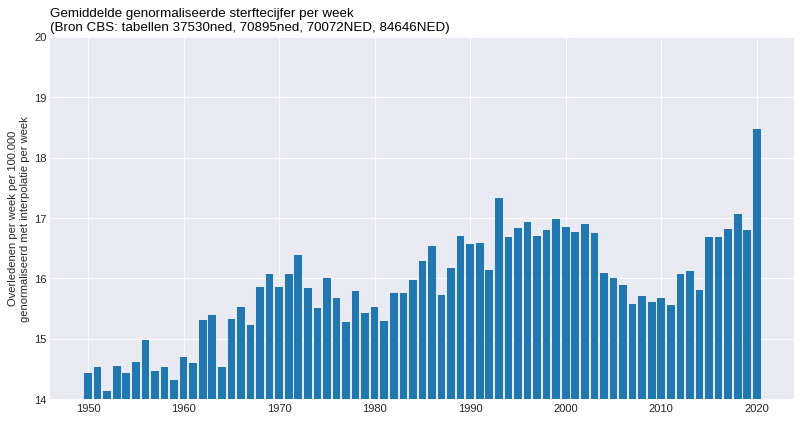

In [10]:
#@title
# Plotting the bar diagram: 1995 till last year
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Gemiddelde genormaliseerde sterftecijfer per week\n(Bron CBS: tabellen 37530ned, 70895ned, 70072NED, 84646NED)", loc='left', fontsize=12, fontweight=0, color='black')
plt.bar(df_till_last['Jaar'], df_till_last['Gem.per week'])
plt.ylabel("Overledenen per week per 100.000\ngenormaliseerd met interpolatie per week")
plt.ylim(14,20)
plt.show()

# Death rate 1995-last year: Jaar, Gem.per week

In [11]:
#@title
df_reference = df_1995_current[df_1995_current['Jaar'] < current_year-1] #2020
# df_other = df_1995_current[df_1995_current['Jaar'] >= current_year -1]
df_other = df_1995_current[(df_1995_current['Jaar'] >= current_year -1) | (df_1995_current['Jaar'] == 2015) | (df_1995_current['Jaar'] == 2018)]


table_reference = pd.pivot_table(df_reference, values='Overledenen Genormaliseerd', index=['Week'],
                       aggfunc={lambda x: np.percentile(x,75),
                                lambda x: np.percentile(x,50),
                                lambda x: np.percentile(x,25),
                                np.max,
                                np.min})

df_all = pd.DataFrame(table_reference.to_records())
df_all = df_all.rename(columns={'amax': 'Max', 'amin': 'Min'})
print(df_all['<lambda_0>'].iloc[0] > df_all['<lambda_2>'].iloc[0])

lambda_0 = df_all['<lambda_0>'].iloc[0]
lambda_1 = df_all['<lambda_1>'].iloc[0]
lambda_2 = df_all['<lambda_2>'].iloc[0]
lambda_list = [lambda_0, lambda_1, lambda_2]

for x, item in enumerate(lambda_list):
  if item == max(lambda_list):
    df_all.rename(columns={'<lambda_'+str(x)+'>': 'P75'}, inplace=True)
  elif item == min(lambda_list):
    df_all.rename(columns={'<lambda_'+str(x)+'>': 'P25'}, inplace=True)
  else:
    df_all.rename(columns={'<lambda_'+str(x)+'>': 'Mediaan'}, inplace=True)
  
df_all = df_all[['Week', 'Max', 'P75', 'Mediaan', 'P25', 'Min']]

table_other = pd.pivot_table(df_other, values='Overledenen Genormaliseerd', columns=['Jaar'], index=['Week'])
df_other = pd.DataFrame(table_other.to_records())

# merge
df_all = pd.merge(df_all, df_other, how='left', left_on=['Week'], right_on=['Week'])
headers=['Week', 'Max', 'P75', 'Mediaan', 'P25', 'Min']
for item in df_other.columns:
  if item != 'Week':
    headers.append(item)
print(tabulate(df_all, headers=headers, tablefmt='orgtbl'))

True
|    |   Week |    Max |     P75 |   Mediaan |     P25 |    Min |   2015 |    2018 |   2020 |    2021 |
|----+--------+--------+---------+-----------+---------+--------+--------+---------+--------+---------|
|  0 |      1 | 22.886 | 19.457  |   18.292  | 17.513  | 16.436 | 19.26  |  19.457 | 17.837 |  23.447 |
|  1 |      2 | 21.669 | 19.548  |   18.445  | 17.342  | 16.339 | 20.287 |  19.548 | 19.333 |  21.706 |
|  2 |      3 | 20.866 | 19.165  |   18.178  | 16.957  | 15.442 | 19.978 |  19.575 | 18.13  |  21.782 |
|  3 |      4 | 21.22  | 19.112  |   18.294  | 16.898  | 15.726 | 19.834 |  19.329 | 17.49  | nan     |
|  4 |      5 | 20.914 | 19.019  |   18.153  | 17.182  | 16.086 | 19.649 |  19.798 | 18.159 | nan     |
|  5 |      6 | 20.435 | 19.189  |   17.87   | 16.946  | 16.053 | 19.352 |  20.435 | 18.334 | nan     |
|  6 |      7 | 21.288 | 18.971  |   17.464  | 16.889  | 15.728 | 19.581 |  21.288 | 18.36  | nan     |
|  7 |      8 | 21.466 | 19.129  |   18.042  | 17.184  | 15

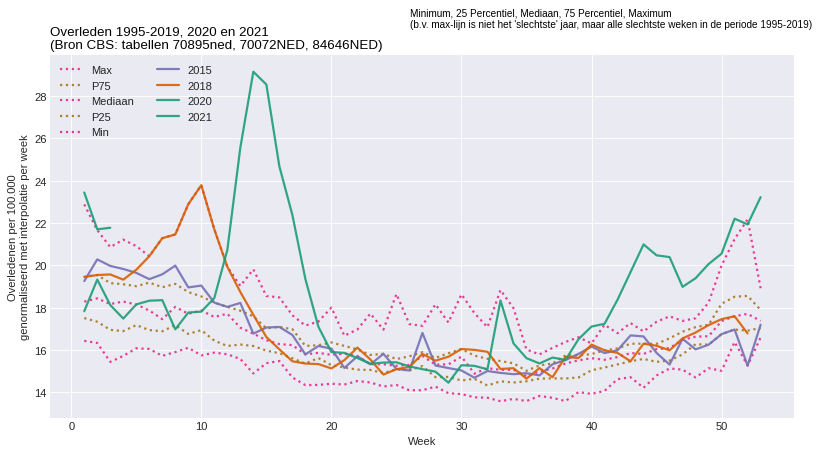

In [12]:
#@title
# multiple line plot
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
num = 9
for column in df_all.drop('Week', axis=1):
    num += 1
    linestyle = 'solid'
    line_width = 7
    if column[0:1] == 'P':
        num = 1
        linestyle = 'dotted'
        linewidth = 2
    if column[0:1] == 'M':
        num = 4
        linestyle = 'dotted'
        linewidth = 2
    if column == "Median":
        num = 0
        linestyle='dotted'
        linewidth = 2
    plt.plot(df_all['Week'], df_all[column],
             marker='', color=palette(num),
             linewidth=linewidth, alpha=0.9, label=column,
             linestyle=linestyle)

# Add legend
plt.legend(loc=2, ncol=2)

# Add titles
plt.title("Overleden 1995-2019, 2020 en 2021\n(Bron CBS: tabellen 70895ned, 70072NED, 84646NED)", loc='left', fontsize=12, fontweight=0, color='black')
plt.suptitle("Minimum, 25 Percentiel, Mediaan, 75 Percentiel, Maximum\n(b.v. max-lijn is niet het 'slechtste' jaar, maar alle slechtste weken in de periode 1995-2019)", horizontalalignment = 'left', fontsize=9, fontweight=0, color='black')
plt.xlabel("Week")
plt.ylabel("Overledenen per 100.000\ngenormaliseerd met interpolatie per week")
plt.show()